In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import process_time


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda device


In [4]:
def soft_thresholding(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)
def Difference_matrix(n_k):
    D1 = np.zeros((n_k-1, n_k))
    for i in range(n_k-1):
        D1[i, i] = -1
        D1[i, i+1] = 1
    return D1
def sep_groups(n,k):
    groups = {i: [] for i in range(k)}
    for item in range(n):
        group_number = item % (k)
        groups[group_number].append(item)
    max_len = max(len(group) for group in groups.values())
    return groups , max_len  
    

### Standard ADMM

In [5]:
def admm(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]

    D1=Difference_matrix(n_k)
    D=np.dot(D1,D)
    
    beta = np.zeros(n)
    alpha = np.zeros(n_k-1)
    u = np.zeros(n_k-1)
    for k in range(max_iter):
        # Update beta
        A = np.eye(n) + rho * D.T @ D
        b = y + rho * D.T @ (alpha + u)
        beta = np.linalg.solve(A, b)

        # Update alpha
        alpha = soft_thresholding(D @ beta - u, lambd / rho)

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence (this is just an example)
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Standard ADMM -----")
    print("Time execution:", end - begin)
    return beta,k

### cd for ADMM

In [6]:
def admm_cd(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]
    k=n-n_k
    
    D1=Difference_matrix(n_k)
    D=np.dot(D1,D)
    beta = np.zeros(n)
    alpha = np.zeros(n_k-1)
    u = np.zeros(n_k-1)

    indices = np.arange(n)
    for i in range(max_iter):
        # Update beta using coordinate descent
        res=rho*D.T@(alpha+u)
        DTD=D.T@D
        np.random.shuffle(indices)
        for j in indices:
            beta_sum = np.dot(DTD[j,:], beta) - DTD[j, j] * beta[j]
            beta[j] = (y[j] + res[j] - rho * beta_sum) / (1 + rho * DTD[j, j])

        # Update alpha
        alpha = soft_thresholding(D @ beta - u, lambd / rho)

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Standard cdADMM -----")
    print("Time execution:", end - begin)        
    return beta,i

### cdADMM with blocks
$ D \in \mathbb{R}^{(n-k) \times n}$, $ D^T D $ has at most $ 2k+1$ non-zero elements in each row.    Therefore, at most $ 2 k$ elements are relevant with one $ \beta_{i} $, yielding that the blocks need to be separated into $2k+1$ parts.

In [7]:
def admm_cd_withblock(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]
    k=n-n_k
    
    D1=Difference_matrix(n_k)
    D=np.dot(D1,D)
    beta = np.zeros(n)
    alpha = np.zeros(n_k-1)
    u = np.zeros(n_k-1)
    groups,max_len = sep_groups(n,2*k+3) 
    for i in range(max_iter):
        # Update beta using coordinate descent
        res=rho*D.T@(alpha+u)
        DTD=D.T@D
        for item in range(2*k+3):
            group=groups[item]
            np.random.shuffle(group)
            for j in range(max_len):                
                if j<len(group):
                    beta_sum = np.dot(DTD[group[j],:], beta) - DTD[group[j],group[j]] * beta[group[j]]
                    beta[group[j]] = (y[group[j]] + res[group[j]] - rho * beta_sum) / (1 + rho * DTD[group[j], group[j]])

        # Update alpha
        alpha = soft_thresholding(D @ beta - u, lambd / rho)

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Standard cdADMM with blocks-----")
    print("Time execution:", end - begin)        
    return beta,i

### Specialized ADMM

In [8]:
import cvxpy as cp
def Spe_admm(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]
    beta = np.zeros(n)
    alpha_value = np.zeros(n_k)
    D_1=Difference_matrix(n_k)
    u = np.zeros(n_k)
    for k in range(max_iter):
        # Update beta
        A = np.eye(n) + rho * D.T @ D
        b = y + rho * D.T @ (alpha_value + u)
        beta = np.linalg.solve(A, b)

        # Update alpha
        alpha = cp.Variable(n_k)
        # set objective
        objective = cp.Minimize(0.5 * cp.norm2(D @ beta - u - alpha)**2 + (lambd/rho) * cp.norm1(D_1 @ alpha))
        # define and solve the problem
        problem = cp.Problem(objective)
        problem.solve()

        # upd alpha
        alpha_value = alpha.value
        # Update u
        u = u + alpha_value - D @ beta

        # Check for convergence (this is just an example)
        if np.linalg.norm(D @ beta - alpha_value) < tol:
            break
    end = process_time()
    print("----- Specialized ADMM -----")
    print("Time execution:", end - begin)    
    return beta,k

### cd for specialized ADMM:

In [9]:
def Spe_admm_cd(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]
    k=n-n_k

    beta = np.zeros(n)
    alpha = np.zeros(n_k)
    u = np.zeros(n_k)
    D_1=Difference_matrix(n_k)

    indices = np.arange(n)
    for i in range(max_iter):
        # Update beta using coordinate descent
        res=rho*D.T@(alpha+u)
        DTD=D.T@D
        np.random.shuffle(indices) # randomize
        for j in indices:
            beta_sum = np.dot(DTD[j,:], beta) - DTD[j, j] * beta[j]
            beta[j] = (y[j] + res[j] - rho * beta_sum) / (1 + rho * DTD[j, j])

        # Update alpha using cvxpy
        alpha_value = cp.Variable(n_k)
        objective = cp.Minimize(0.5 * cp.norm2(D @ beta - u - alpha_value)**2 + (lambd/rho) * cp.norm1(D_1 @ alpha_value))
        problem = cp.Problem(objective)
        problem.solve()
        alpha = alpha_value.value

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Specialized cdADMM -----")
    print("Time execution:", end - begin)    
    return beta,i

### cd for Specialized ADMM with blocks

In [10]:
def Spe_admm_cd_withblocks(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k=D.shape[0]
    k=n-n_k

    beta = np.zeros(n)
    alpha = np.zeros(n_k)
    u = np.zeros(n_k)
    D_1=Difference_matrix(n_k)
    groups,max_len = sep_groups(n,2*k+1) 
    for i in range(max_iter):
        # Update beta using coordinate descent
        res=rho*D.T@(alpha+u)
        DTD=D.T@D
        for item in range(2*k+1):
            group=groups[item]
            np.random.shuffle(group)
            for j in range(max_len):
                if j<len(group): # if j is in the group
                    beta_sum = np.dot(DTD[group[j],:], beta) - DTD[group[j],group[j]] * beta[group[j]]
                    beta[group[j]] = (y[group[j]] + res[group[j]] - rho * beta_sum) / (1 + rho * DTD[group[j], group[j]])

        # Update alpha
        alpha_value = cp.Variable(n_k)
        objective = cp.Minimize(0.5 * cp.norm2(D @ beta - u - alpha_value)**2 + (lambd/rho) * cp.norm1(D_1 @ alpha_value))
        problem = cp.Problem(objective)
        problem.solve()

        # 输出更新后的 alpha 值
        alpha = alpha_value.value

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Specialized cdADMM with blocks-----")
    print("Time execution:", end - begin)    
    return beta,i

### Using 'threading' package to achieve parallel computing

In [11]:
import numpy as np
import cvxpy as cp
import threading

def coordinate_descent(DTD, beta, y, res, rho, indices):
    """Coordinate descent for a subset of beta indices."""
    for j in indices:
        beta_sum = np.dot(DTD[j, :], beta) - DTD[j, j] * beta[j]
        beta[j] = (y[j] + res[j] - rho * beta_sum) / (1 + rho * DTD[j, j])

def Spe_admm_cd_parallel(y, D, lambd, rho, max_iter=100, tol=1e-4):
    begin = process_time()
    n = y.shape[0]
    n_k = D.shape[0]
    beta = np.zeros(n)
    alpha = np.zeros(n_k)
    u = np.zeros(n_k)
    D_1 = Difference_matrix(n_k)  # Assuming this function is defined elsewhere

    for k in range(max_iter):
        res = rho * D.T @ (alpha + u)
        DTD = D.T @ D

        # Parallel coordinate descent
        num_threads = 4  # Define the number of threads
        chunk_size = n // num_threads
        threads = []
        for i in range(num_threads):
            start = i * chunk_size
            if i == num_threads - 1:
                end = n
            else:
                end = start + chunk_size
            thread = threading.Thread(target=coordinate_descent, args=(DTD, beta, y, res, rho, range(start, end)))
            threads.append(thread)
            thread.start()

        for thread in threads:
            thread.join()

        # Update alpha
        alpha_value = cp.Variable(n_k)
        objective = cp.Minimize(0.5 * cp.norm2(D @ beta - u - alpha_value)**2 + (lambd/rho) * cp.norm1(D_1 @ alpha_value))
        problem = cp.Problem(objective)
        problem.solve()
        alpha = alpha_value.value

        # Update u
        u = u + alpha - D @ beta

        # Check for convergence
        if np.linalg.norm(D @ beta - alpha) < tol:
            break
    end = process_time()
    print("----- Specialized cdADMM with parallel -----")
    print("Time execution:", end - begin)
    return beta, k


In [12]:

np.random.seed(0)
n = 500
k=1

x = np.linspace(0, 10, n)
true_signal = np.sin(x)  # real signal
noise = np.random.normal(0, 0.5, n)  # Gaussian noise
y = true_signal + noise  # signal with noise
n_k = n - k
D=Difference_matrix(n)
# define difference matrix D
for i in range(1,k):
    D1=Difference_matrix(n-i)
    D=np.dot(D1,D)

lambd = 1.0  # regularization parameter
rho = 1.5  # penalty parameter of ADMM
max_iter = 1000  # maximum number of iterations
tol = 1e-4  # convergence tolerance

beta1,iter1 = admm(y, D, lambd, rho, max_iter, tol)
beta2,iter2 = admm_cd(y, D, lambd, rho, max_iter, tol)
beta2_withblocks,iter2_withblocks = admm_cd_withblock(y, D, lambd, rho, max_iter, tol)
beta3,iter3 = Spe_admm(y, D, lambd, rho, max_iter, tol)
beta4,iter4 = Spe_admm_cd(y, D, lambd, rho, max_iter, tol)
beta4_withblocks,iter4_withblocks = Spe_admm_cd_withblocks(y, D, lambd, rho, max_iter, tol)
beta5,iter5 = Spe_admm_cd_parallel(y, D, lambd, rho, max_iter, tol)

----- Standard ADMM -----
Time execution: 1291.330523038
----- Standard cdADMM -----
Time execution: 401.9444085040002
----- Standard cdADMM with blocks-----
Time execution: 377.9627524539999
----- Specialized ADMM -----
Time execution: 261.07479827199995
----- Specialized cdADMM -----
Time execution: 177.0616725279997
----- Specialized cdADMM with blocks-----
Time execution: 181.24391855600015
----- Specialized cdADMM with parallel -----
Time execution: 199.79442087500001


### iteration

In [13]:

print(
    f"Standard ADMM: {iter1+1}\n"
    f"Standard ADMM with cd: {iter2+1}\n"
    f"Standard cdADMM with blocks: {iter2_withblocks+1}\n"
    f"Specialized ADMM: {iter3+1}\n"
    f"Specialized ADMM with cd: {iter4+1}\n"
    f"Specialized cdADMM with blocks: {iter4_withblocks+1}\n"
    f"Specialized ADMM with parallel cd: {iter5+1}"
)


Standard ADMM: 1000
Standard ADMM with cd: 1000
Standard cdADMM with blocks: 1000
Specialized ADMM: 54
Specialized ADMM with cd: 44
Specialized cdADMM with blocks: 45
Specialized ADMM with parallel cd: 43


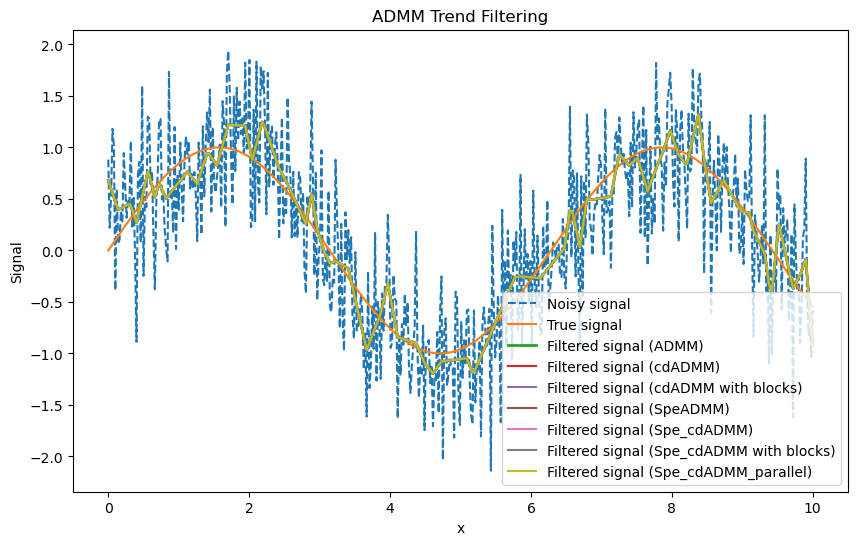

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Noisy signal', linestyle='--')
plt.plot(x, true_signal, label='True signal')
plt.plot(x, beta1, label='Filtered signal (ADMM)', linewidth=2)
plt.plot(x, beta2, label='Filtered signal (cdADMM)')
plt.plot(x,beta2_withblocks,label='Filtered signal (cdADMM with blocks)')
plt.plot(x, beta3, label='Filtered signal (SpeADMM)')
plt.plot(x, beta4, label='Filtered signal (Spe_cdADMM)')
plt.plot(x,beta4_withblocks,label='Filtered signal (Spe_cdADMM with blocks)')
plt.plot(x, beta5, label='Filtered signal (Spe_cdADMM_parallel)')
plt.legend()
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('ADMM Trend Filtering')
plt.show()

In [15]:
np.random.seed(0)
n = 100
k=2

x = np.linspace(0, 10, n)
true_signal = np.sin(x)  # real signal
noise = np.random.normal(0, 0.5, n)  # Gaussian noise
y = true_signal + noise  # signal with noise
n_k = n - k
D=Difference_matrix(n)
# define difference matrix D
for i in range(1,k):
    D1=Difference_matrix(n-i)
    D=np.dot(D1,D)

lambd = 1.0  # regularization parameter
rho = 2  # penalty parameter of ADMM
max_iter = 1000  # maximum number of iterations
tol = 1e-4  # convergence tolerance

beta2_1,iter2_1 = admm(y, D, lambd, rho, max_iter, tol)
beta2_2,iter2_2 = admm_cd(y, D, lambd, rho, max_iter, tol)
beta2_2_withblocks,iter2_2_withblocks = admm_cd_withblock(y, D, lambd, rho, max_iter, tol)
beta2_3,iter2_3 = Spe_admm(y, D, lambd, rho, max_iter, tol)
beta2_4,iter2_4 = Spe_admm_cd(y, D, lambd, rho, max_iter, tol)
beta2_4_withblocks,iter2_4_withblocks = Spe_admm_cd_withblocks(y, D, lambd, rho, max_iter, tol)
beta2_5,iter2_5 = Spe_admm_cd_parallel(y, D, lambd, rho, max_iter, tol)


----- Standard ADMM -----
Time execution: 21.553661400999772
----- Standard cdADMM -----
Time execution: 37.55950784300012
----- Standard cdADMM with blocks-----
Time execution: 38.17898016800018
----- Specialized ADMM -----
Time execution: 110.08431244299982
----- Specialized cdADMM -----
Time execution: 191.12726696800019
----- Specialized cdADMM with blocks-----
Time execution: 163.49288954200028
----- Specialized cdADMM with parallel -----
Time execution: 477.716019854


### iteration

In [16]:

print(
    f"Standard ADMM: {iter2_1+1}\n"
    f"Standard ADMM with cd: {iter2_2+1}\n"
    f"Standard ADMM with cd blocks: {iter2_2_withblocks+1}\n"
    f"Specialized ADMM: {iter2_3+1}\n"
    f"Specialized ADMM with cd: {iter2_4+1}\n"
    f"Specialized ADMM with cd blocks: {iter2_4_withblocks+1}\n"
    f"Specialized ADMM with parallel cd: {iter2_5+1}"
)

Standard ADMM: 323
Standard ADMM with cd: 480
Standard ADMM with cd blocks: 472
Specialized ADMM: 62
Specialized ADMM with cd: 105
Specialized ADMM with cd blocks: 91
Specialized ADMM with parallel cd: 250


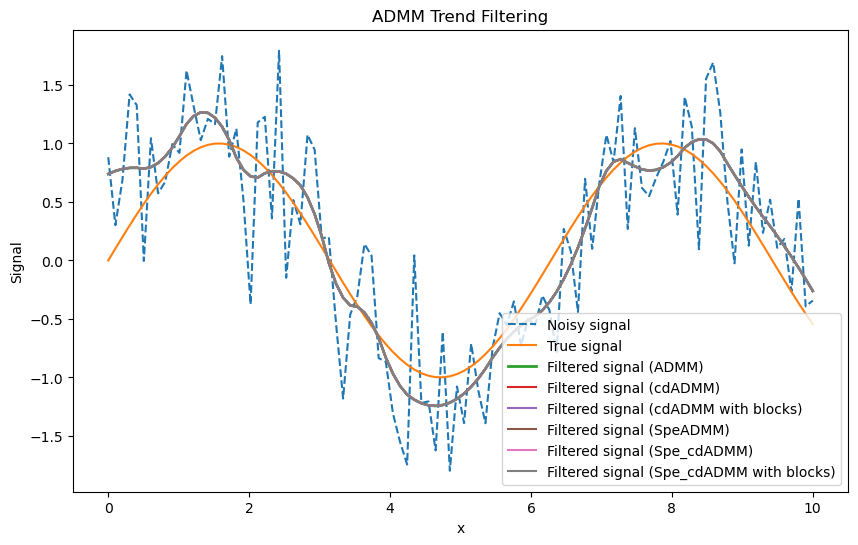

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Noisy signal', linestyle='--')
plt.plot(x, true_signal, label='True signal')
plt.plot(x, beta2_1, label='Filtered signal (ADMM)', linewidth=2)
plt.plot(x, beta2_2, label='Filtered signal (cdADMM)')
plt.plot(x,beta2_2_withblocks, label='Filtered signal (cdADMM with blocks)')
plt.plot(x, beta2_3, label='Filtered signal (SpeADMM)')
plt.plot(x, beta2_4, label='Filtered signal (Spe_cdADMM)')
plt.plot(x,beta2_4_withblocks, label='Filtered signal (Spe_cdADMM with blocks)')
plt.legend()
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('ADMM Trend Filtering')
plt.show()


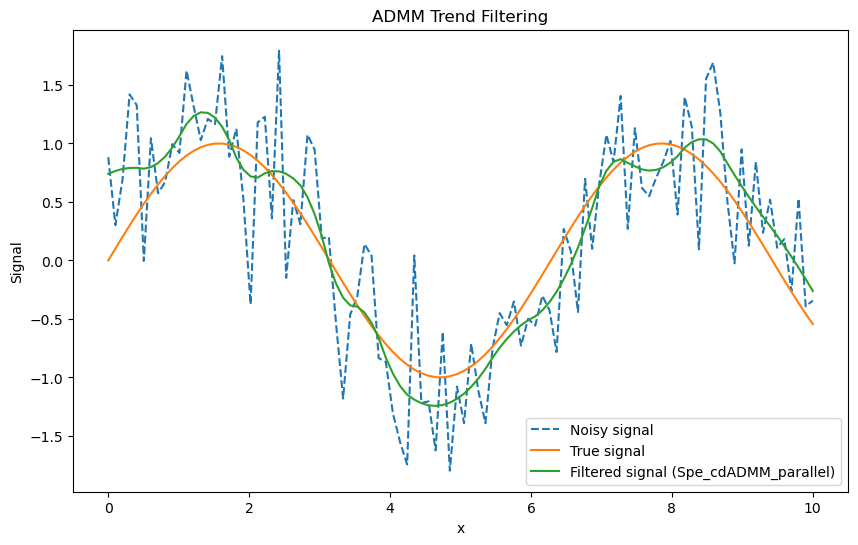

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Noisy signal', linestyle='--')
plt.plot(x, true_signal, label='True signal')
plt.plot(x, beta2_5, label='Filtered signal (Spe_cdADMM_parallel)') # parallel version is not stable
plt.legend()
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('ADMM Trend Filtering')
plt.show()